In [1]:
import os
import glob
import cv2
from matplotlib import pyplot as plt
import numpy as np

We write a function to read .pgm files which is format of YaleB dataset.

In [2]:
def read_pgm(pgmf):
    """Return a raster of integers from a PGM as a list of lists."""
    #print (pgmf.readline())
    assert pgmf.readline() == b'P5\n'
    (width, height) = [int(i) for i in pgmf.readline().split()]
    depth = int(pgmf.readline())
    assert depth <= 255

    raster = []
    for y in range(height):
        row = []
        for y in range(width):
            row.append(ord(pgmf.read(1)))
        raster.append(row)
    return raster

In [3]:
YALEB_DATASET = 'data/YaleB'

We read the dataset and visualize some images. We discard the persons which have less than 50 face images to reduce noise and variance.

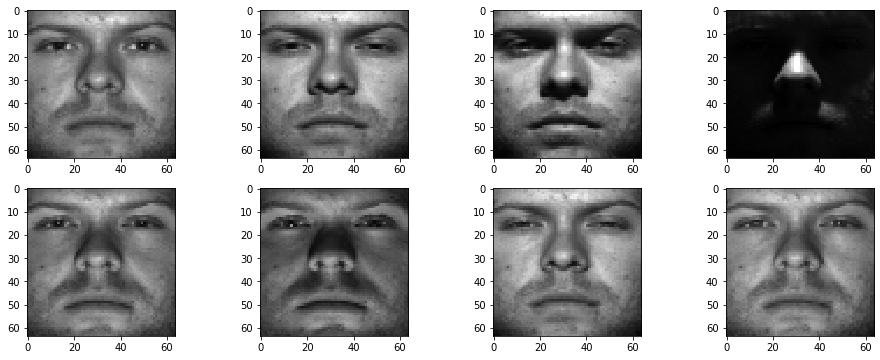

Read 2425 images of 38 persons from YaleB dataset


In [4]:
n_imgs = 2425
width, height = 64,64
yaleb_imgs = np.zeros((n_imgs, height, width ,), dtype=np.float32)
yaleb_labels = np.zeros((n_imgs, ))
fig = plt.figure(figsize=(16, 6))
i = 1
unique_labels = {}
c = 0
for root, dirs, files in os.walk(YALEB_DATASET):
    for file in files:
        if file.endswith(".pgm"):
            img_path = os.path.join(root, file)
            with open(img_path, 'rb') as f:
                try:
                    img = read_pgm(f)
                except:
                    continue
            label = root.split('/')[-1]
            if label not in unique_labels:
                unique_labels[label] = c
                c+=1
            img = np.array(img, dtype=np.uint8)[:,:,np.newaxis]
            img = cv2.resize(img[:,:,0], (width, height))
            yaleb_imgs[i-1] = img[:,:]
            yaleb_labels[i-1] = unique_labels[label]
            if i <= 8:
                plt.subplot(2, 4, i)
                plt.imshow(img[:,:], cmap='gray', vmin=0, vmax=255) 
            i+=1
plt.show()
print ("Read %s images of %s persons from YaleB dataset"%(i,c))


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(yaleb_imgs, yaleb_labels, test_size=0.2, random_state=42)

X_train = X_train.reshape(-1,width*height)
X_test = X_test.reshape(-1,width*height)

## Principal Comoponent Analysis

We now compute Principal Component Analysis which extracts eigenfaces of the train dataset. The PCA's transformation matrix will be later used for testing.

In [6]:
from sklearn.decomposition import PCA
n_components = 128
print("Extracting the top {} eigenfaces from {} faces".format(n_components, X_train.shape[0]))
pca = PCA(n_components=n_components, whiten=True).fit(X_train)

# Transform data into principal components representation
print("Transforming the test data using the the orthonormal basis of PCA")
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

Extracting the top 128 eigenfaces from 1940 faces
Transforming the test data using the the orthonormal basis of PCA


In [7]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=15)
model.fit(X_train_pca, y_train,)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

In [8]:
# Evaluation of the model
y_pred = model.predict(X_test_pca)

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
print(classification_report(y_test, y_pred, ))

              precision    recall  f1-score   support

         0.0       0.40      1.00      0.57         8
         1.0       1.00      0.85      0.92        13
         2.0       0.83      1.00      0.91        15
         3.0       0.90      0.86      0.88        21
         4.0       0.80      0.67      0.73        12
         5.0       1.00      1.00      1.00        11
         6.0       0.82      0.95      0.88        19
         7.0       0.79      0.83      0.81        18
         8.0       0.79      0.92      0.85        12
         9.0       0.79      0.79      0.79        14
        10.0       1.00      0.75      0.86        12
        11.0       1.00      0.67      0.80         9
        12.0       1.00      0.93      0.96        14
        13.0       1.00      0.88      0.93        16
        14.0       1.00      1.00      1.00        12
        15.0       1.00      1.00      1.00        13
        16.0       1.00      1.00      1.00        12
        17.0       1.00    

In [10]:
import sklearn
pca_acc = sklearn.metrics.accuracy_score(y_test, y_pred, )

## Linear Discriminant Analysis

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
model = LinearDiscriminantAnalysis()
model.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [12]:
# Evaluation of the model
y_pred = model.predict(X_test)

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
print(classification_report(y_test, y_pred, ))

              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94         8
         1.0       1.00      0.85      0.92        13
         2.0       1.00      1.00      1.00        15
         3.0       1.00      0.95      0.98        21
         4.0       1.00      0.83      0.91        12
         5.0       1.00      1.00      1.00        11
         6.0       1.00      1.00      1.00        19
         7.0       1.00      0.94      0.97        18
         8.0       1.00      1.00      1.00        12
         9.0       1.00      0.86      0.92        14
        10.0       1.00      1.00      1.00        12
        11.0       1.00      0.89      0.94         9
        12.0       1.00      1.00      1.00        14
        13.0       1.00      1.00      1.00        16
        14.0       1.00      1.00      1.00        12
        15.0       1.00      0.92      0.96        13
        16.0       1.00      1.00      1.00        12
        17.0       1.00    

In [14]:
import sklearn
lda_acc = sklearn.metrics.accuracy_score(y_test, y_pred, )

## Non-Negative Matrix Factorization

In [15]:
from sklearn.decomposition import NMF
model = NMF(n_components=128, init='random', random_state=0)
X_train_nmf = model.fit_transform(X_train)
X_test_nmf = model.transform(X_test)

In [16]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=15)
model.fit(X_train_nmf, y_train,)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

In [17]:
# Evaluation of the model
y_pred = model.predict(X_test_nmf)

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
print(classification_report(y_test, y_pred, ))

              precision    recall  f1-score   support

         0.0       0.26      0.75      0.39         8
         1.0       0.53      0.62      0.57        13
         2.0       0.86      0.80      0.83        15
         3.0       0.55      0.57      0.56        21
         4.0       0.62      0.67      0.64        12
         5.0       0.80      0.73      0.76        11
         6.0       0.59      0.53      0.56        19
         7.0       0.48      0.61      0.54        18
         8.0       0.50      0.83      0.62        12
         9.0       0.50      0.36      0.42        14
        10.0       0.80      0.33      0.47        12
        11.0       0.23      0.33      0.27         9
        12.0       1.00      0.64      0.78        14
        13.0       0.75      0.75      0.75        16
        14.0       0.50      0.33      0.40        12
        15.0       0.62      0.62      0.62        13
        16.0       0.67      0.83      0.74        12
        17.0       0.46    

In [19]:
import sklearn
nmf_acc = sklearn.metrics.accuracy_score(y_test, y_pred, )

## Independent Component Analysis

In [20]:
from sklearn.decomposition import FastICA
model = FastICA(n_components=128, random_state=0)
X_train_ica = model.fit_transform(X_train)
X_test_ica = model.transform(X_test)

In [21]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=15)
model.fit(X_train_ica, y_train,)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

In [22]:
# Evaluation of the model
y_pred = model.predict(X_test_ica)

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
print(classification_report(y_test, y_pred, ))

              precision    recall  f1-score   support

         0.0       0.38      1.00      0.55         8
         1.0       1.00      0.85      0.92        13
         2.0       0.88      1.00      0.94        15
         3.0       0.95      0.90      0.93        21
         4.0       0.82      0.75      0.78        12
         5.0       0.92      1.00      0.96        11
         6.0       0.78      0.95      0.86        19
         7.0       0.89      0.89      0.89        18
         8.0       0.85      0.92      0.88        12
         9.0       0.80      0.86      0.83        14
        10.0       1.00      0.75      0.86        12
        11.0       1.00      0.67      0.80         9
        12.0       1.00      0.93      0.96        14
        13.0       1.00      0.94      0.97        16
        14.0       1.00      1.00      1.00        12
        15.0       1.00      0.92      0.96        13
        16.0       1.00      1.00      1.00        12
        17.0       1.00    

In [24]:
import sklearn
ica_acc = sklearn.metrics.accuracy_score(y_test, y_pred, )

## Singular Value Decomposition

In [25]:
from sklearn.decomposition import TruncatedSVD
model = TruncatedSVD(n_components=128, random_state=0)
X_train_svd = model.fit_transform(X_train)
X_test_svd = model.transform(X_test)

In [26]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=15)
model.fit(X_train_svd, y_train,)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

In [27]:
# Evaluation of the model
y_pred = model.predict(X_test_svd)

In [28]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
print(classification_report(y_test, y_pred, ))

              precision    recall  f1-score   support

         0.0       0.27      1.00      0.42         8
         1.0       0.77      0.77      0.77        13
         2.0       0.82      0.60      0.69        15
         3.0       0.39      0.76      0.52        21
         4.0       0.50      0.67      0.57        12
         5.0       0.35      0.64      0.45        11
         6.0       0.31      0.53      0.39        19
         7.0       0.69      0.61      0.65        18
         8.0       0.56      0.83      0.67        12
         9.0       0.36      0.29      0.32        14
        10.0       1.00      0.42      0.59        12
        11.0       0.50      0.44      0.47         9
        12.0       0.92      0.79      0.85        14
        13.0       0.83      0.62      0.71        16
        14.0       0.67      0.17      0.27        12
        15.0       0.83      0.38      0.53        13
        16.0       1.00      0.92      0.96        12
        17.0       0.62    

In [29]:
import sklearn
svd_acc = sklearn.metrics.accuracy_score(y_test, y_pred, )

## Locality Preserving Projection

In [30]:
!pip3 install lpproj
from lpproj import LocalityPreservingProjection 
model = LocalityPreservingProjection(n_components=128, )
X_train_lpp = model.fit_transform(X_train)
X_test_lpp = model.transform(X_test)

In [31]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=15)
model.fit(X_train_lpp, y_train,)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

In [32]:
# Evaluation of the model
y_pred = model.predict(X_test_lpp)

In [33]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
print(classification_report(y_test, y_pred, ))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         8
         1.0       0.00      0.00      0.00        13
         2.0       0.00      0.00      0.00        15
         3.0       0.00      0.00      0.00        21
         4.0       0.00      0.00      0.00        12
         5.0       0.00      0.00      0.00        11
         6.0       0.00      0.00      0.00        19
         7.0       0.00      0.00      0.00        18
         8.0       0.03      0.58      0.06        12
         9.0       0.00      0.00      0.00        14
        10.0       0.00      0.00      0.00        12
        11.0       0.00      0.00      0.00         9
        12.0       0.00      0.00      0.00        14
        13.0       0.00      0.00      0.00        16
        14.0       0.00      0.00      0.00        12
        15.0       0.00      0.00      0.00        13
        16.0       0.00      0.00      0.00        12
        17.0       0.00    

C:\Users\khushalpt\anaconda33\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
import sklearn
lpp_acc = sklearn.metrics.accuracy_score(y_test, y_pred, )

## Comparing different techniques

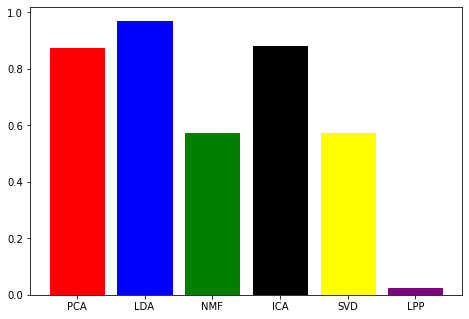

In [35]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
tech = ['PCA', 'LDA', 'NMF', 'ICA', 'SVD', 'LPP']
accs = [pca_acc, lda_acc, nmf_acc, ica_acc, svd_acc, lpp_acc]
bars = ax.bar(tech, accs)
bars[0].set_color('red')
bars[1].set_color('blue')
bars[2].set_color('green')
bars[3].set_color('black')
bars[4].set_color('yellow')
bars[5].set_color('purple')
plt.show()

The best two methods are LDA and PCA. Now we combine both techniques by first applying PCA over data, then apply LDA on the concatenation of PCA and raw input features.

## LDA and PCA Combination

In [36]:
from sklearn.decomposition import PCA
n_components = 128
print("Extracting the top {} eigenfaces from {} faces".format(n_components, X_train.shape[0]))
pca = PCA(n_components=n_components, whiten=True).fit(X_train)

# Transform data into principal components representation
print("Transforming the test data using the the orthonormal basis of PCA")
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

Extracting the top 128 eigenfaces from 1940 faces
Transforming the test data using the the orthonormal basis of PCA


In [37]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
model = LinearDiscriminantAnalysis()
X_train_lda = model.fit_transform(np.concatenate((X_train, X_train_pca), axis=1), y_train)

In [38]:
# Evaluation of the model
y_pred = model.predict(np.concatenate((X_test, X_test_pca), axis=1))

In [39]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
print(classification_report(y_test, y_pred, ))

              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94         8
         1.0       1.00      0.85      0.92        13
         2.0       1.00      1.00      1.00        15
         3.0       1.00      0.95      0.98        21
         4.0       1.00      0.83      0.91        12
         5.0       1.00      1.00      1.00        11
         6.0       1.00      1.00      1.00        19
         7.0       1.00      0.94      0.97        18
         8.0       1.00      1.00      1.00        12
         9.0       1.00      0.86      0.92        14
        10.0       1.00      1.00      1.00        12
        11.0       1.00      0.89      0.94         9
        12.0       1.00      1.00      1.00        14
        13.0       1.00      1.00      1.00        16
        14.0       1.00      1.00      1.00        12
        15.0       1.00      0.92      0.96        13
        16.0       1.00      1.00      1.00        12
        17.0       1.00    